<a href="https://colab.research.google.com/github/Nguyennd507/MachineLearning/blob/master/Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!unzip /content/drive/'My Drive'/Data/flowers-recognition.zip
# !ln -s /content/drive/'My Drive'/ML/backup /content

In [ ]:
# Thêm thư viện
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
from imutils import paths
from keras.applications import VGG16
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelBinarizer
from keras import models
from keras import layers
from keras import optimizers
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.externals import joblib
import cv2
from pathlib import Path
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
flowers_path=Path('/content/flowers/flowers')
flower_types = os.listdir(flowers_path)
flowers = []
for species in flower_types:
    all_flowers = os.listdir(flowers_path / species)
    for flower in all_flowers:
        flowers.append((species, str(flowers_path /species) + '/' + flower))
     
flowers = pd.DataFrame(data=flowers, columns=['category', 'image'], index=None)
flowers.head()

,category,image
0,tulip,/content/flowers/flowers/tulip/17282288501_e87...
1,tulip,/content/flowers/flowers/tulip/7166546934_c97b...
2,tulip,/content/flowers/flowers/tulip/8713388322_e5ae...
3,tulip,/content/flowers/flowers/tulip/8619064872_dea7...
4,tulip,/content/flowers/flowers/tulip/3282751630_45c2...


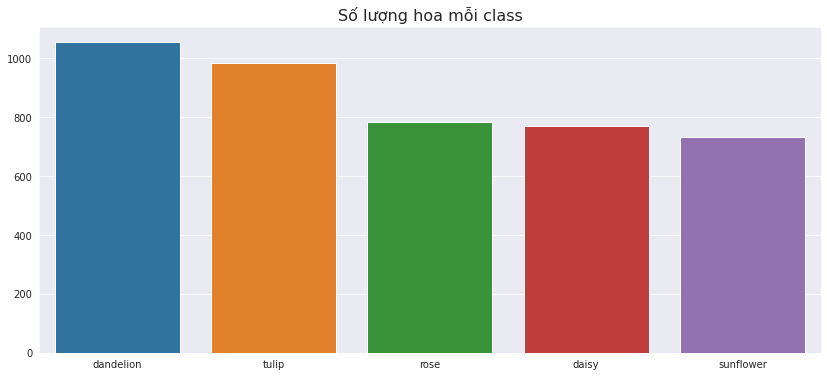

In [ ]:
fl_count = flowers['category'].value_counts()
f, axe = plt.subplots(1,1,figsize=(14,6))
sns.barplot(x = fl_count.index, y = fl_count.values, ax = axe)
axe.set_title("Số lượng hoa mỗi class", fontsize=16)
#axe.set_xlabel('class', fontsize=14)
#axe.set_ylabel('số lượng', fontsize=14)
plt.show()

In [ ]:
# Lấy các đường dẫn đến ảnh.
image_path = list(paths.list_images('/content/flowers/flowers'))

# Đổi vị trí ngẫu nhiên các đường dẫn ảnh
random.shuffle(image_path)

In [ ]:
# Đường dẫn ảnh sẽ là dataset/tên_loài_hoa/tên_ảnh ví dụ dataset/Bluebell/image_0241.jpg nên p.split(os.path.sep)[-2] sẽ lấy ra được tên loài hoa
labels = [p.split(os.path.sep)[-2] for p in image_path]

# Chuyển tên các loài hoa thành số
# le = LabelEncoder()
# labels = le.fit_transform(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [ ]:
# Load model VGG 16 của ImageNet dataset, include_top=False để bỏ phần Fully connected layer ở cuối.
model = VGG16(weights='imagenet', include_top=False)

In [ ]:
# Load ảnh và resize về đúng kích thước mà VGG 16 cần là (224,224)
list_image = []
for (j, imagePath) in enumerate(image_path):
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    
    image = np.expand_dims(image, 0)
    image = imagenet_utils.preprocess_input(image)
    
    list_image.append(image)
    
list_image = np.vstack(list_image)

In [ ]:
from keras.backend import clear_session
clear_session()

# Load model VGG 16 của ImageNet dataset, include_top=False để bỏ phần Fully connected layer ở cuối.
conv_base  = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(5, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                

In [ ]:
# Chia traing set, test set tỉ lệ 80-20
X_train, X_test, y_train, y_test = train_test_split(list_image, labels, test_size=0.2, random_state=42)

In [ ]:
# augmentation cho training data
aug_train = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                         zoom_range=0.2, horizontal_flip=True)
# augementation cho test
aug_test= ImageDataGenerator(rescale=1./255)

In [ ]:
# freeze VGG model
for layer in conv_base.layers:
    layer.trainable = False
    
opt = Adam(2e-5)
model.compile(opt, 'categorical_crossentropy', ['accuracy'])
numOfEpoch = 20
H = model.fit_generator(aug_train.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=len(X_train)//32,
                        validation_data=(aug_test.flow(X_test, y_test, batch_size=32)),
                        validation_steps=len(X_test)//32,
                        epochs=numOfEpoch)

#unfreeze some last CNN layer:
for layer in conv_base.layers[15:]:
    layer.trainable = True

numOfEpoch = 25
opt = Adam(2e-5)
model.compile(opt, 'categorical_crossentropy', ['accuracy'])
H1 = model.fit_generator(aug_train.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=len(X_train)//32,
                        validation_data=(aug_test.flow(X_test, y_test, batch_size=32)),
                        validation_steps=len(X_test)//32,
                        epochs=numOfEpoch)

Epoch 1/20
108/108 [==============================] - 64s 595ms/step - loss: 1.5179 - accuracy: 0.3579 - val_loss: 0.9611 - val_accuracy: 0.6169
Epoch 2/20
108/108 [==============================] - 58s 540ms/step - loss: 1.1583 - accuracy: 0.5309 - val_loss: 0.8376 - val_accuracy: 0.6915
Epoch 3/20
108/108 [==============================] - 57s 531ms/step - loss: 0.9872 - accuracy: 0.6211 - val_loss: 0.8323 - val_accuracy: 0.7335
Epoch 4/20
108/108 [==============================] - 57s 530ms/step - loss: 0.8883 - accuracy: 0.6719 - val_loss: 0.5610 - val_accuracy: 0.7539
Epoch 5/20
108/108 [==============================] - 57s 527ms/step - loss: 0.8345 - accuracy: 0.6824 - val_loss: 0.6501 - val_accuracy: 0.7539
Epoch 6/20
108/108 [==============================] - 57s 524ms/step - loss: 0.7961 - accuracy: 0.6999 - val_loss: 0.3738 - val_accuracy: 0.7659
Epoch 7/20
108/108 [==============================] - 57s 525ms/step - loss: 0.7295 - accuracy: 0.7309 - val_loss: 0.7386 - val_ac

In [ ]:
H.history['loss'].extend(H1.history['loss'])
H.history['accuracy'].extend(H1.history['accuracy'])
H.history['val_loss'].extend(H1.history['val_loss'])
H.history['val_accuracy'].extend(H1.history['val_accuracy'])

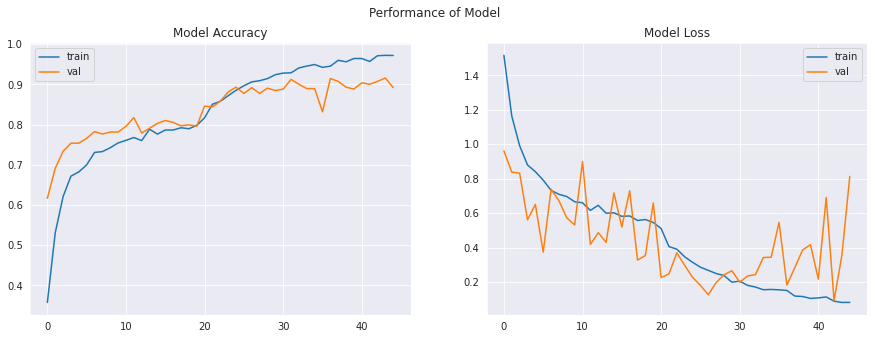

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("Performance of Model")
ax1.plot(H.history['accuracy'])
ax1.plot(H.history['val_accuracy'])
vline_cut = np.where(H.history['val_accuracy'] == np.max(H.history['val_accuracy']))[0][0]
ax1.set_title("Model Accuracy")
ax1.legend(['train', 'val'])

ax2.plot(H.history['loss'])
ax2.plot(H.history['val_loss'])
vline_cut = np.where(H.history['val_loss'] == np.min(H.history['val_loss']))[0][0]
ax2.set_title("Model Loss")
ax2.legend(['train', 'val'])
plt.show()

In [ ]:
y_pred = model.predict(X_test)
rounded_labels=np.argmax(y_test, axis=1)
rounded_pred=np.argmax(y_pred, axis=1)
print(confusion_matrix(rounded_labels,rounded_pred),'\n')
print(classification_report(rounded_labels,rounded_pred))

[[135   8   0   7   7]
 [ 16 183   0  10   3]
 [  6   3  81  10  56]
 [  2   3   0 130   4]
 [  3   1   6   9 182]] 

              precision    recall  f1-score   support

           0       0.83      0.86      0.85       157
           1       0.92      0.86      0.89       212
           2       0.93      0.52      0.67       156
           3       0.78      0.94      0.85       139
           4       0.72      0.91      0.80       201

    accuracy                           0.82       865
   macro avg       0.84      0.82      0.81       865
weighted avg       0.84      0.82      0.82       865



In [ ]:
joblib.dump(model, '/content/drive/My Drive/Data/Fine_Tuning.pkl')

['/content/drive/My Drive/Data/Fine_Tuning.pkl']